# VAE编码器网络

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3 ,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)   #shape_before_flattening = (None, 14, 14, 64)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

encoder = Model(input_img, [z_mean, z_log_var])

In [3]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [4]:
print(K.shape(z_mean))
print(K.shape(z_mean)[0])
z_mean.shape[0]

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("strided_slice:0", shape=(), dtype=int32)


Dimension(None)

# 潜在空间采样的函数

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
z

<tf.Tensor 'lambda_1/add:0' shape=(?, 2) dtype=float32>

In [6]:
K.int_shape(z)

(None, 2)

# VAE解码器网络

In [7]:
"""
numpy.prod(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>)
Return the product of array elements over a given axis.
Parameters: a : array_like
                Input data.
            axis : None or int or tuple of ints, optional
                   Axis or axes along which a product is performed. 
                   The default, axis=None, will calculate the product of all the elements 
                   in the input array. If axis is negative it counts from the last to the 
                   first axis.
"""

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)   #shape_before_flattening = (None, 14, 14, 64)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

In [8]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [9]:
z_decoded = decoder(z)
z_decoded

<tf.Tensor 'model_2/conv2d_5/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

# 用于计算VAE损失的自定义层

In [10]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

# 训练VAE

In [14]:
from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_train.shape + (1,))

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

11493376/11490434 [==============================] - 7s 1us/step
(60000, 28, 28)
(60000, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 254s 4ms/step - loss: 0.2135 - val_loss: 0.1962
Epoch 2/10
60000/60000 [==============================] - 255s 4ms/step - loss: 0.1940 - val_loss: 0.1929
Epoch 3/10
60000/60000 [==============================] - 255s 4ms/step - loss: 0.1896 - val_loss: 0.1879
Epoch 4/10
60000/60000 [==============================] - 254s 4ms/step - loss: 0.1870 - val_loss: 0.1855
Epoch 5/10
60000/60000 [==============================] - 255s 4ms/step - loss: 0.1855 - val_loss: 0.1854
Epoch 6/10
60000/60000 [==============================] - 254s 4ms/step - loss: 0.1841 - val_loss: 0.1831
Epoch 7/10
60000/60000 [==============================] - 255s 4ms/step - loss: 0.1831 - val_loss: 0.1824
Epoch 8/10
60000/60000 [==============================] - 255s 4ms/step - loss: 0.1824 - val_loss: 0.1819
Ep

In [17]:
vae.save('vae.h5')
encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [2]:
from keras.models import load_model
#vae = load_model('vae.h5')
#encoder = load_model('encoder.h5')
decoder = load_model('decoder.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


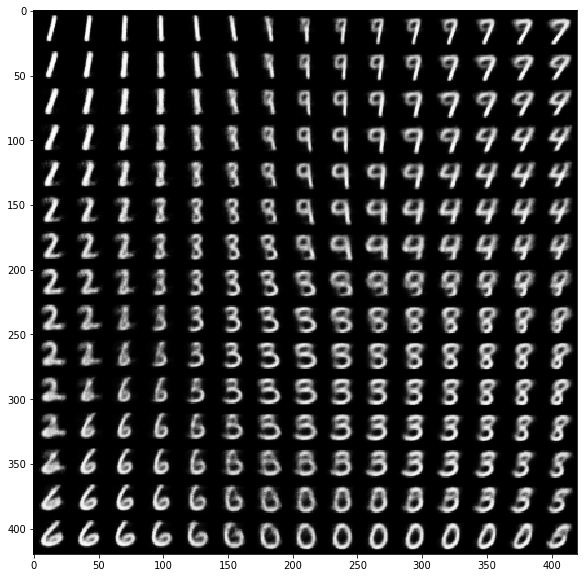

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

batch_size = 16
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print('grid x', grid_x)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [11]:
x = norm.ppf(np.linspace(0.05, 0.95, n))
y = norm.ppf(np.linspace(0.05, 0.95, n))
print('x: ', x)
z = np.array([[x[0], y[0]]])
print('z: ', z)
z = np.tile(z, batch_size).reshape(batch_size, 2)
print('z after tile: ', z)
x_decoded = decoder.predict(z, batch_size=batch_size)
print('x_decoded.shape: ', x_decoded.shape)
digit = x_decoded[0].reshape(digit_size, digit_size)
print('digit.shape: ', digit.shape)

x:  [-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
z:  [[-1.64485363 -1.64485363]]
z after tile:  [[-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]]
x_decoded.shape:  (16, 28, 28, 1)
digit.shape:  (28, 28)


In [13]:
np.tile(np.array([[x[0], y[0]]]), batch_size)

array([[-1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363, -1.64485363, -1.64485363, -1.64485363,
        -1.64485363, -1.64485363]])